In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Water Level/NTWL/Srimangal-Dhalay.csv')
#the daily dataset
print(df.shape)
df.head()

(19457, 2)


,Date,WL(m)
0,4/1/1964,18.70
1,4/2/1964,19.20
2,4/3/1964,19.63
3,4/4/1964,19.87
4,4/5/1964,20.19


In [4]:
#checking types
df.dtypes

Date      object
WL(m)    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

            Date   WL(m)
0       4/1/1964  18.700
1       4/2/1964  19.200
2       4/3/1964  19.630
3       4/4/1964  19.870
4       4/5/1964  20.190
...          ...     ...
19452  4/26/2019  15.130
19453  4/27/2019  15.120
19454  4/28/2019  15.120
19455  4/29/2019  15.304
19456  4/30/2019  15.178

[19457 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,Date,WL(m)
0,4/1/1964,18.70
1,4/2/1964,19.20
2,4/3/1964,19.63
3,4/4/1964,19.87
4,4/5/1964,20.19


In [8]:
df.tail()

,Date,WL(m)
19452,4/26/2019,15.130
19453,4/27/2019,15.120
19454,4/28/2019,15.120
19455,4/29/2019,15.304
19456,4/30/2019,15.178


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
# df_pr.sort_values('Date', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('Date', inplace=True)
df_pr.head()

,WL(m)
Date,
4/1/1964,18.70
4/2/1964,19.20
4/3/1964,19.63
4/4/1964,19.87
4/5/1964,20.19


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Srimangal-Dhalay_monthly.csv")

(661, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1964-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 661
Total year: 55


Data Visulalization
----------

About Data

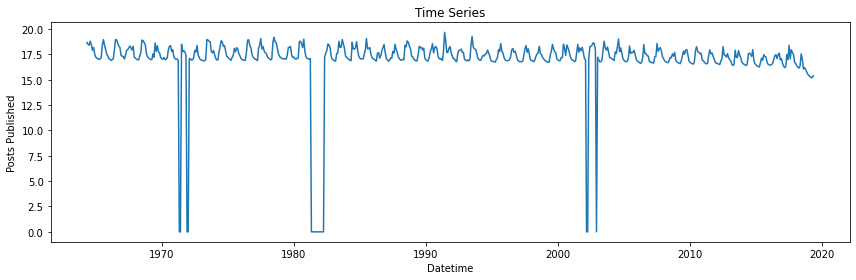

In [12]:
# 7.Plotting the time series
monthly['WL(m)'] = monthly['WL(m)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(549, 1), Validation=(112, 1)


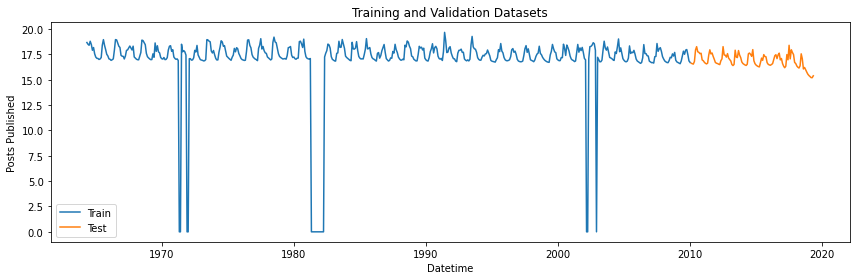

In [13]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

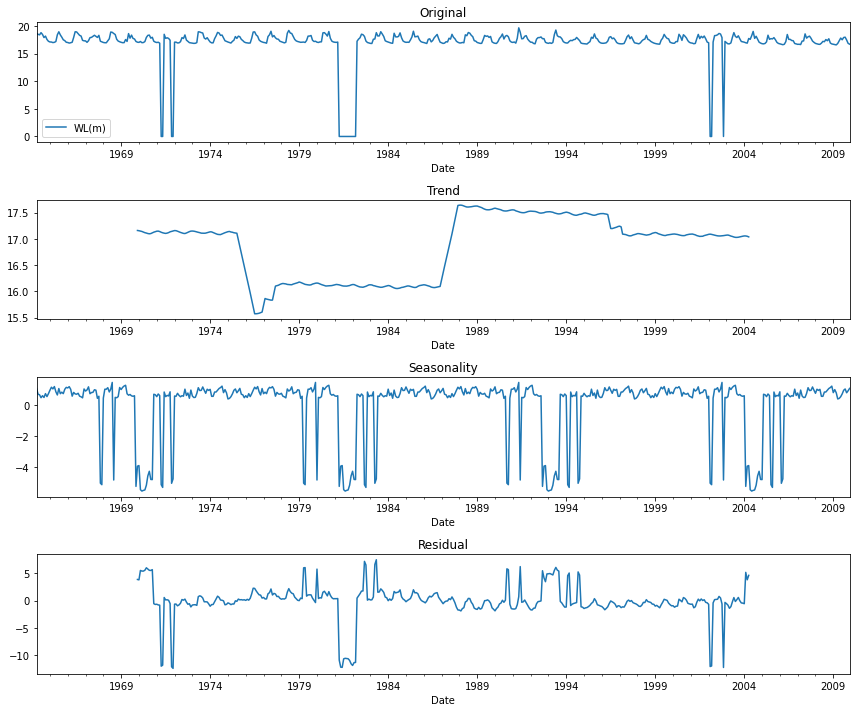

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

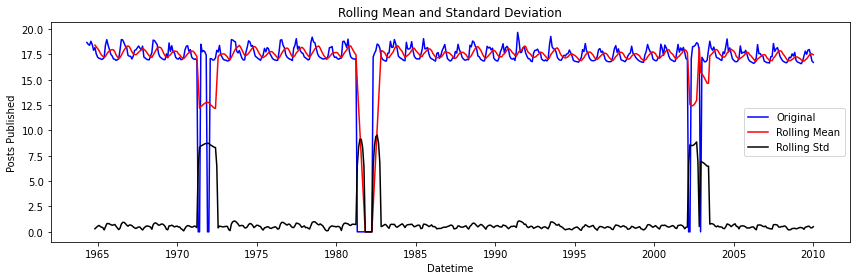

Results of Dickey-Fuller Test:
Test Statistic                -5.806837e+00
P-Value                        4.495957e-07
#Lags Used                     9.000000e+00
Number of Observations Used    5.390000e+02
Critical Value (1%)           -3.442541e+00
Critical Value (5%)           -2.866917e+00
Critical Value (10%)          -2.569634e+00
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  WL(m)   No. Observations:                  549
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1214.964
Date:                Sun, 06 Nov 2022   AIC                           2447.928
Time:                        18:51:09   BIC                           2486.685
Sample:                    04-30-1964   HQIC                          2463.076
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5238      1.294     -0.405      0.686      -3.059       2.012
ar.L2         -0.4209      0.218     -1.932      0.053      -0.848       0.006
ar.L3         -0.2727      0.471     -0.579      0.5

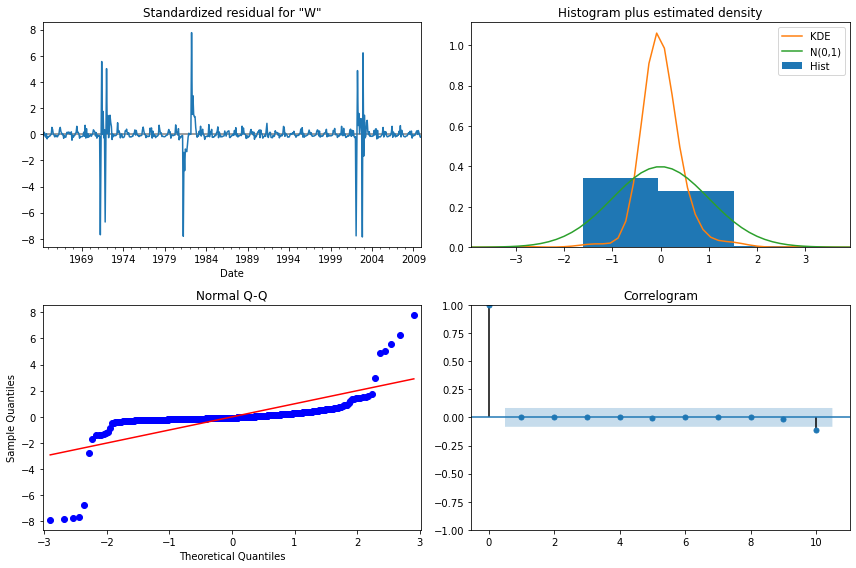

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

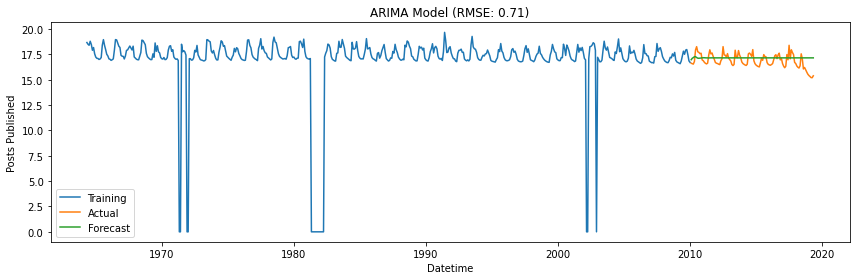

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31    16.984433
2010-02-28    17.122018
2010-03-31    17.190822
2010-04-30    17.278690
2010-05-31    17.279329
                ...    
2018-12-31    17.166182
2019-01-31    17.166182
2019-02-28    17.166182
2019-03-31    17.166182
2019-04-30    17.166182
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  0.7099960888385106


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              WL(m)   No. Observations:                  549
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood               -1193.392
Date:                            Sun, 06 Nov 2022   AIC                           2420.784
Time:                                    18:53:57   BIC                           2493.615
Sample:                                04-30-1964   HQIC                          2449.277
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3392      0.724      0.468      0.640      -1.080       1.759
ar.L2         -0.2889      0.147   

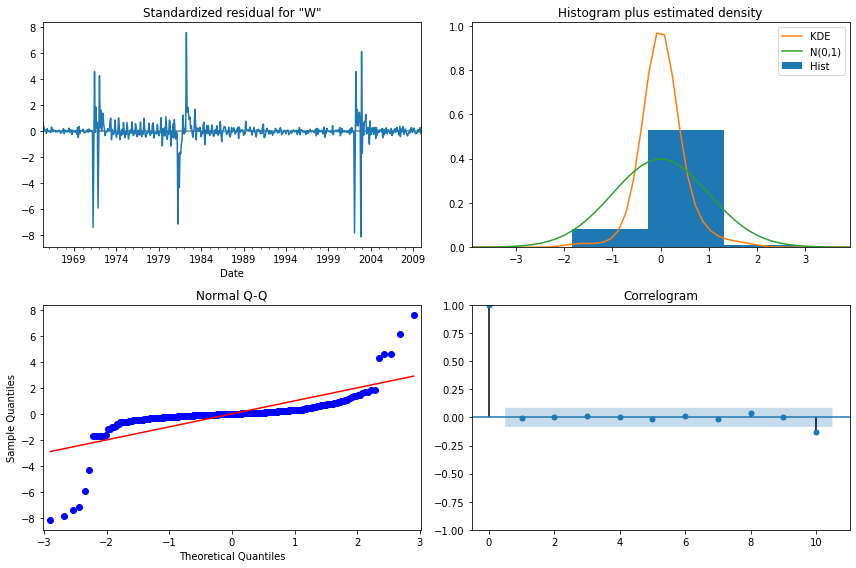

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

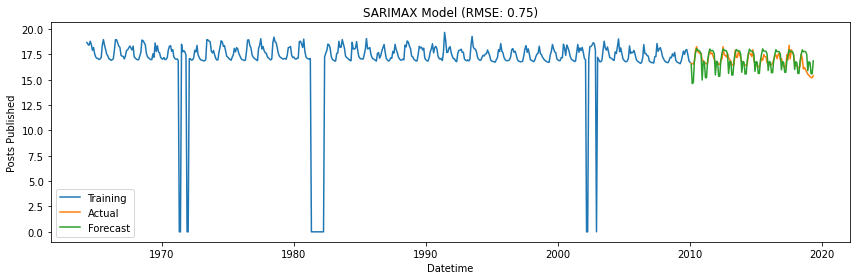

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    16.521005
2010-02-28    14.625107
2010-03-31    14.733020
2010-04-30    16.890588
2010-05-31    17.672213
                ...    
2018-12-31    16.779883
2019-01-31    16.689593
2019-02-28    15.593029
2019-03-31    15.596538
2019-04-30    16.872703
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.7466612894058032


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv("Srimangal-Dhalay_monthly.csv")

In [32]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1964-04-30,18.681000
1,1964-05-31,18.507097
2,1964-06-30,18.408000
3,1964-07-31,18.805806
4,1964-08-31,18.480645


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmsuipq6/2ppknp_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptmsuipq6/57mnxphr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94247', 'data', 'file=/tmp/tmptmsuipq6/2ppknp_p.json', 'init=/tmp/tmptmsuipq6/57mnxphr.json', 'output', 'file=/tmp/tmptmsuipq6/prophet_modelz08yzt47/prophet_model-20221106185400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1964-04-30
1   1964-05-31
2   1964-06-30
3   1964-07-31
4   1964-08-31
..         ...
728 2024-12-31
729 2025-01-31
730 2025-02-28
731 2025-03-31
732 2025-04-30

[733 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1964-04-30,17.829494,17.019749,17.902630,17.829494,17.829494,-0.367063,-0.367063,-0.367063,-0.367063,-0.367063,-0.367063,0.0,0.0,0.0,17.462431
1,1964-05-31,17.826500,17.642284,18.554984,17.826500,17.826500,0.297501,0.297501,0.297501,0.297501,0.297501,0.297501,0.0,0.0,0.0,18.124001
2,1964-06-30,17.823602,18.125089,19.011409,17.823602,17.823602,0.744089,0.744089,0.744089,0.744089,0.744089,0.744089,0.0,0.0,0.0,18.567691
3,1964-07-31,17.820607,17.931462,18.830692,17.820607,17.820607,0.574128,0.574128,0.574128,0.574128,0.574128,0.574128,0.0,0.0,0.0,18.394735
4,1964-08-31,17.817613,17.921146,18.837750,17.817613,17.817613,0.568684,0.568684,0.568684,0.568684,0.568684,0.568684,0.0,0.0,0.0,18.386296


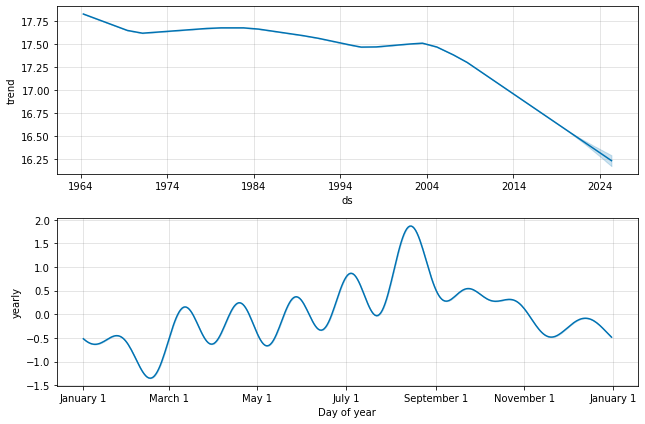

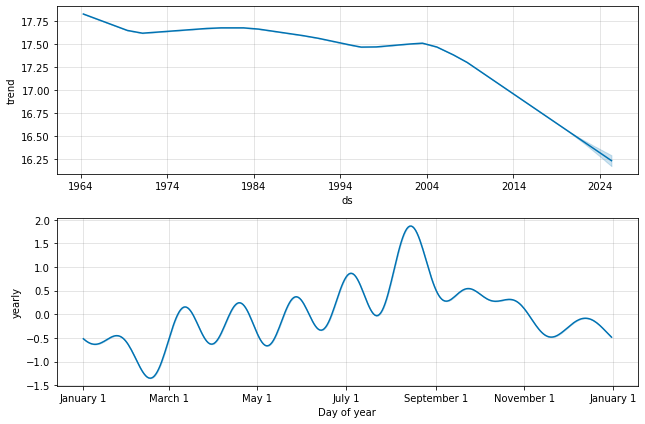

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1964-04-30  17.462431
1964-05-31  18.124001
1964-06-30  18.567691
1964-07-31  18.394735
1964-08-31  18.386296
...               ...
2024-12-31  15.759039
2025-01-31  15.645280
2025-02-28  15.615448
2025-03-31  15.603255
2025-04-30  15.879451

[733 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1964-04-30    17.462431
1964-05-31    18.124001
1964-06-30    18.567691
1964-07-31    18.394735
1964-08-31    18.386296
                ...    
2024-12-31    15.759039
2025-01-31    15.645280
2025-02-28    15.615448
2025-03-31    15.603255
2025-04-30    15.879451
Name: yhat, Length: 733, dtype: float64


In [40]:
print(valid)

                WL(m)
Date                 
2010-01-31  16.641290
2010-02-28  16.590000
2010-03-31  16.551613
2010-04-30  16.809133
2010-05-31  17.950323
...               ...
2018-12-31  15.422839
2019-01-31  15.320323
2019-02-28  15.217714
2019-03-31  15.210581
2019-04-30  15.396133

[112 rows x 1 columns]


In [41]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [42]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.39986969068926304


-----------------

MODEL Comparison
----------

Testing

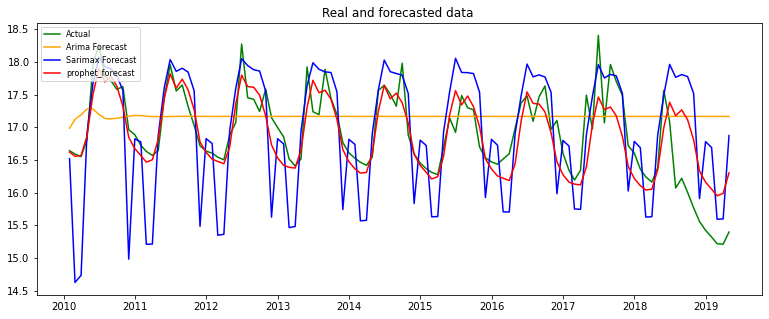

In [43]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

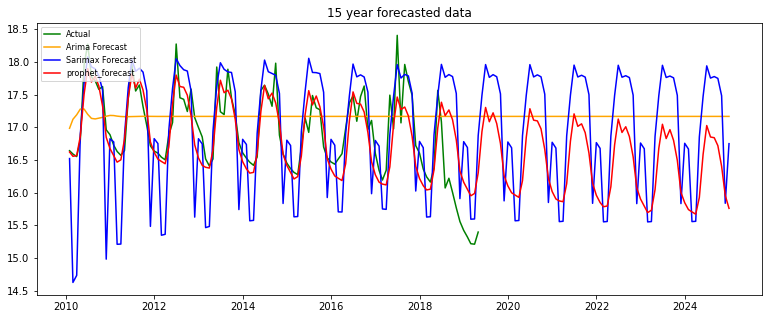

In [44]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

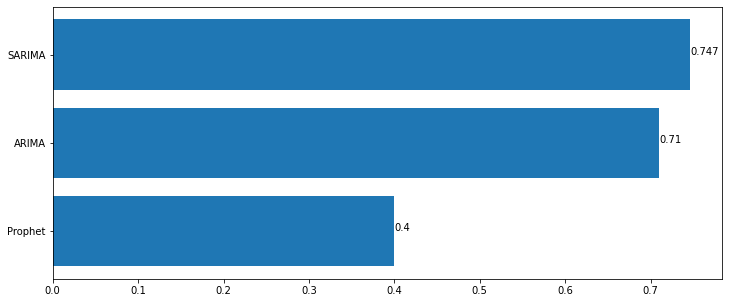

In [45]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [46]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2019-11-31

Choose the correct date according to the mentioned format


In [47]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Srimangal-Dhalay-monthly_merged.csv")